# Sustainable Portfolio Selection: An Approach to Impact Modeling

In our article [Sustainable Portfolio Selection -- Markowitz goes ESG](https://developers.lseg.com/en/article-catalog/article/SustainablePortfolioSelection) we describe the importance of ecological, social and governance (ESG) aspects of financial services and give a first approach, how ESG measures can be included into portfolio selection strategies.  Basically, ESG-ratings of financial instruments, like for instance LSEG's ESG Scores, can be mathematically treated similar to mean historical returns. As a result, one can balance estimates for risk and/or return with ESG-ratings and compute portfolios of financial instruments with high average ESG Score as well as good risk measures.

In this follow-up article we adhere to the fact that high ESG-ratings can have a different impact in different industrial sectors or countries. We will show, how impact data can be integrated into portfolio selection models with ESG-awareness.  

### Overview

In this tutorial you can learn 
 * to get business sector information from LSEG and to plot the sector distribution of a weighted portfolio;
 * how to balance volatility as a risk measure with portfolio returns and ESG-measures in portfolio selection;
 * about the basics of impact modeling, and how sector impact information can be included into portfolio selection. 
 
We build on the steps in [Sustainable Portfolio Selection -- Markowitz goes ESG](https://developers.lseg.com/en/article-catalog/article/SustainablePortfolioSelection), where basically a classical Markowitz model is employed, but returns are replaced by ESG-ratings. This tutorial is structured as follows: 
 * **Step 1** Get data via the Data Library, prepare the basic data structures. 
 * **Step 2** Build the minimum volatility portfolio (MVP) and analyze its business sector distribution.
 * **Step 3** Build a portfolio, where volatility is balanced with return and also the *ESG-score*. 
 * **Step 4** Build a model for impact-ESG and utilize it to select a portfolio, where volatility is balanced with return and the *impact-ESG-score*.


### Technical prerequisites

 * LSEG Workspace with access to the Data Library (Free Trial Available)
 * Python 3.x
 * Required Python Packages: lseg.data, pandas 0.17.0 or higher, numpy, random, scipy, matplotlib, os


In [1]:
import pandas
import numpy
import random
import matplotlib.pyplot as plt
import scipy.optimize as sco 
import os
import lseg.data as ld

ld.open_session()

<lseg.data.session.Definition object at 0x18bffdce5d0 {name='workspace'}>

## Data acquisition and universe selection
Our portfolio will be built from a universe (or a pre-selection) of shares. We will work based on the ETF iShares Core MSCI World UCITS ETF USD which refers to the MSCI World index. In difference to our earlier article, we enforce a lower bound on the ESG rating of financial instruments in the portfolio universe just from the beginning. 

### Reading the universe from the Data Platform
We use LSEG Data Library to retrieve the data from Data Platform to get the constituents of the index. For simplicity we will reduce the list of entries here to 350. Besides the instrument identifer RIC, we load company names, their TR ESG Scores as well as the NACE Classification data which refers to the "Statistical Classification of Economic Activities in the European Community". Lateron, this data will be used to constitute an sector-related ESG impact. 

In [2]:
N = 350
constituents = ld.get_data(['IWDA.L'], ['TR.FundHoldingRIC', 'TR.FundHoldingName'])
constituents.rename(columns={'Holding RIC': 'ric', 'Holding Name': 'name'}, inplace=True)
constituents = constituents[['ric','name']][0:N].drop_duplicates(subset=['ric'])
ric_list = list(constituents.ric[constituents.ric.astype(bool)])

df_esg = ld.get_data(ric_list, ['TR.CommonName', 'TR.TRESGScore','TR.BusinessSummary','TR.NACEClassification'])
df_esg = df_esg.rename(columns={'Company Common Name':'name', 'Instrument':'ric', 'ESG Score':'esg', 'NACE Classification':'nace'})
df_esg = df_esg.drop_duplicates(subset=['ric']).set_index('ric')

### Constructing industrial sector information
There exist different classification systems mapping the economic activities of a company to a business sector. LSEG offers a bunch of these business sector information. One can, amongst others, download the sector with respect to the North American Industry Classification System (NAICS), the The Business Classification (TRBC), or -- as it is done here -- the NACE. The data item TR.NACEClassification is composed as follows, 
> BUSINESS SECTOR DESCRIPTION (NACE) (XX.YY)

We will utilize the business division encoded in **XX** and thus extract the string positions [-6:-4]. This data is included to the instruments' pandas dataframe.


In [3]:
nace_code_list =[]
for instr in ric_list:
    df_instr = df_esg.loc[instr]
    nace_code_list.append(df_instr['nace'][-6:-4])
    
df_nace = pandas.DataFrame(data=[ric_list,nace_code_list],index=['ric','nace_code']).T.set_index('ric')
df_esg_nace = pandas.concat([df_esg,df_nace],axis=1)[df_nace['nace_code'].map(len)>0]

Note that in the last line of code we exclude instruments where the NACE division code is missing. 
### Filter those instruments with high ESG Score
We now enforce a strict lower bound on the ESG Score of instruments for the portfolio to ensure a basic quality by means of ecological and social aspects. 

In [4]:
esg_bound = 70
df_esg_constraint = df_esg_nace[(df_esg_nace.esg >= esg_bound)].replace('','nan')
K = len(df_esg_constraint.index)
print('Selected {K} out of {N} instruments by filtering ESG Score >= {esg}\n'.format(K=K,N=N,esg=esg_bound))
df_esg_constraint

Selected 9 out of 350 instruments by filtering ESG Score >= 70



,name,esg,Business Description,nace,nace_code
ric,,,,,
NVDA.OQ,NVIDIA Corp,77.67419,NVIDIA Corporation is a full-stack computing i...,Manufacture of computers and peripheral equipm...,26
MSFT.OQ,Microsoft Corp,90.876817,Microsoft Corporation is a technology company....,Other software publishing (NACE) (58.29),58
AAPL.OQ,Apple Inc,75.422553,"Apple Inc. designs, manufactures and markets s...",Manufacture of communication equipment (NACE) ...,26
AMZN.OQ,Amazon.com Inc,83.310527,"Amazon.com, Inc. provides a range of products ...",Other retail sale of new goods in specialised ...,47
AVGO.OQ,Broadcom Inc,70.407902,Broadcom Inc. is a global technology firm that...,Manufacture of electronic components (NACE) (2...,26
TSLA.OQ,Tesla Inc,71.709711,"Tesla, Inc. designs, develops, manufactures, s...",Manufacture of motor vehicles (NACE) (29.10),29
GOOGL.OQ,Alphabet Inc,80.829744,Alphabet Inc. is a holding company. The Compan...,Web portals (NACE) (63.12),63
GOOG.OQ,Alphabet Inc,80.829744,Alphabet Inc. is a holding company. The Compan...,Web portals (NACE) (63.12),63
JPM.N,JPMorgan Chase & Co,79.803317,JPMorgan Chase & Co. is a financial holding co...,"Other financial service activities, except ins...",64


### Reading instruments time series price data
For the selcted instruments we get the time series data for one year. We need to remove the NA data in order to prevent problems with calculating the covariance matrix.

In [5]:
print('Loading timeseries data from the Data Library')
start='2020-01-01'
end='2020-12-31'
instruments = df_esg_constraint.index
timeseries_data =pandas.DataFrame()
for r in instruments:
    try:
        ts1 = ld.get_history(r,'TRDPRC_1',start=start,end=end,interval='daily')
        ts1.rename(columns = {'TRDPRC_1' : r}, inplace=True)
        timeseries_data =pandas.concat([timeseries_data, ts1], axis=1)
    except:
        continue

timeseries_data = timeseries_data.dropna()
timeseries_data

Loading timeseries data from the Data Library


,NVDA.OQ,MSFT.OQ,AAPL.OQ,AMZN.OQ,AVGO.OQ,TSLA.OQ,GOOGL.OQ,GOOG.OQ,JPM.N
Date,,,,,,,,,
2020-01-02,5.99775,160.62,75.0875,94.9005,32.239,28.683971,68.434,68.3685,141.09
2020-01-03,5.90175,158.62,74.3575,93.7485,31.419,29.53397,68.076,68.033,138.34
2020-01-06,5.9265,159.03,74.95,95.144,31.372,30.102637,69.8905,69.7105,138.23
2020-01-07,5.99825,157.58,74.5975,95.343,31.264,31.270635,69.7555,69.667,135.88
2020-01-08,6.0095,160.09,75.7975,94.5985,30.874,32.809301,70.252,70.216,136.94
...,...,...,...,...,...,...,...,...,...
2020-12-24,12.99375,222.75,131.97,158.6345,43.146,220.589779,86.708,86.9425,124.52
2020-12-28,12.9,224.96,136.69,164.198,43.188,221.229779,88.698,88.8045,125.34
2020-12-29,12.94325,224.15,134.87,166.1,42.904,221.996445,87.888,87.936,125.01


## Minimum Volatility Portfolio (MVP) on the ESG-constrained universe
We compute the classical MVP in the same way as in our [previous article](https://developers.lseg.com/en/article-catalog/article/SustainablePortfolioSelection) -- please consult that tutorial for details. Given the pre-filter on the constituents' ESG Score, the MVP satisfies a lower bound

$$\text{ESG}(\text{MVP}) \geq 70 $$

In [6]:
returns = timeseries_data.pct_change().replace(numpy.inf, numpy.nan).dropna()
covMatrix = returns.cov()

def risk_measure(covMatrix, weights):
    return numpy.dot(weights, numpy.dot(covMatrix, weights))

bounds = K * [(0, 1)]

constraints = {'type': 'eq', 'fun': lambda weights: weights.sum() - 1}

mvp = sco.minimize(lambda x: risk_measure(covMatrix, x),  # function to be minimized
                   K * [1 / K],  # initial guess
                   bounds=bounds,  # box constraints
                   constraints =constraints,  # equality constraints
                   )

print('''MVP in a universe with {K} instruments
Number of selected instruments: {n}
Minimum weight: {minw}
Maximum weight: {maxw}
Historical risk measure: {risk}
Historical return p.a.: {r}
ESG score: {esg}'''.format(K=K,
                           n=numpy.sum(mvp['x']>1e-4),
                           minw=numpy.min(mvp['x'][numpy.nonzero(mvp['x'])]),
                           maxw=numpy.max(mvp['x']),
                           risk=risk_measure(covMatrix, mvp['x']),
                           r=numpy.dot(mvp['x'],returns.sum()),
                           esg=numpy.dot(mvp['x'], df_esg_constraint['esg'])))

MVP in a universe with 9 instruments
Number of selected instruments: 9
Minimum weight: 0.1111111111111111
Maximum weight: 0.1111111111111111
Historical risk measure: 0.0006730184693723141
Historical return p.a.: 0.7002503723783452
ESG score: 78.9849448645182


You may use the the code in the [previous article](https://developers.lseg.com/en/article-catalog/article/SustainablePortfolioSelection) to get further insights into the structure of the resulting MVP. We now go further and plot the distribution of the investment on the NACE divisions:
### Pie chart of the business sectors distribution of the MVP
Given the weight (portion) of each instrument within the (ESG-constrained) portfolio, the portion of the investment within each business sector is accumulated by the function calcWeightsForPieChart(df). Then, a pie chart illustrates, how the money is allotted to business sectors. 

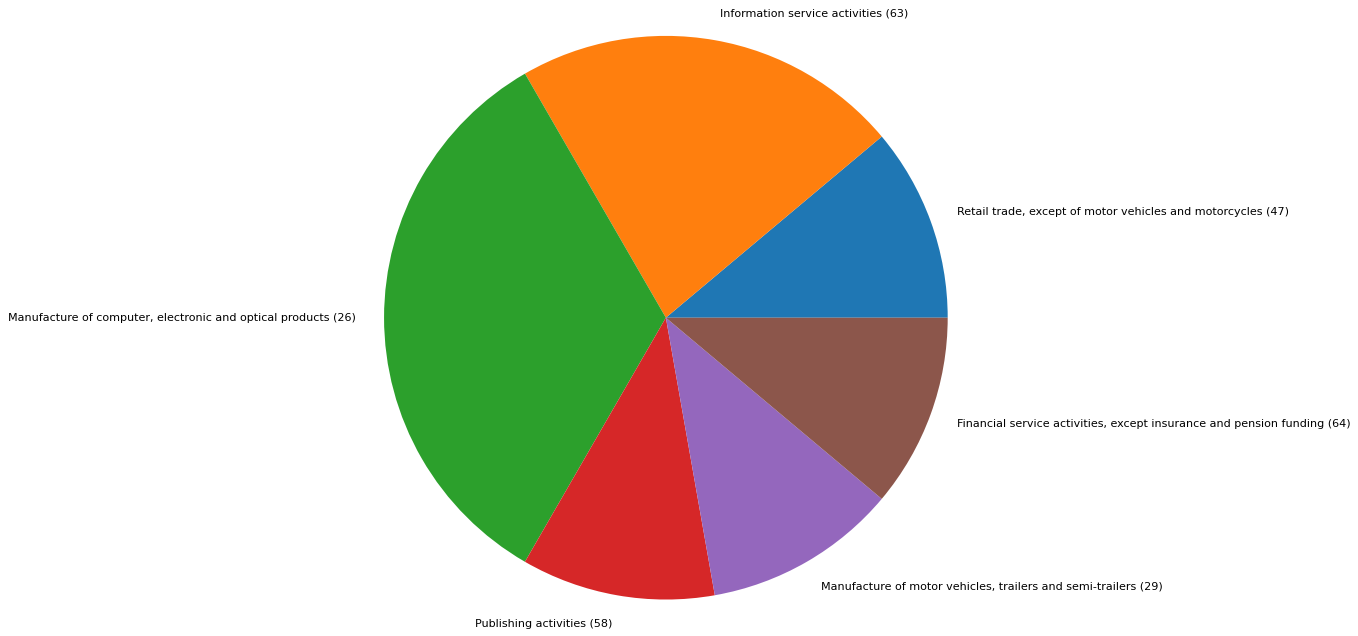

In [7]:
nace_dict ={'01': 'Crop and animal production, hunting and related service activities', '02': 'Forestry and logging', '03': 'Fishing and aquaculture', '05': 'Mining of coal and lignite', '06': 'Extraction of crude petroleum and natural gas', '07': 'Mining of metal ores', '08': 'Other mining and quarrying', '09': 'Mining support service activities', '10': 'Manufacture of food products', '11': 'Manufacture of beverages', '12': 'Manufacture of tobacco products', '13': 'Manufacture of textiles', '14': 'Manufacture of wearing apparel', '15': 'Manufacture of leather and related products', '16': 'Manufacture of wood and of products of wood and cork, except furniture; manufacture of articles of straw and plaiting materials', '17': 'Manufacture of paper and paper products', '18': 'Printing and reproduction of recorded media', '19': 'Manufacture of coke and refined petroleum products', '20': 'Manufacture of chemicals and chemical products', '21': 'Manufacture of basic pharmaceutical products and pharmaceutical preparations', '22': 'Manufacture of rubber and plastic products', '23': 'Manufacture of other non-metallic mineral products', '24': 'Manufacture of basic metals', '25': 'Manufacture of fabricated metal products, except machinery and equipment', '26': 'Manufacture of computer, electronic and optical products', '27': 'Manufacture of electrical equipment', '28': 'Manufacture of machinery and equipment n.e.c.', '29': 'Manufacture of motor vehicles, trailers and semi-trailers', '30': 'Manufacture of other transport equipment', '31': 'Manufacture of furniture', '32': 'Other manufacturing', '33': 'Repair and installation of machinery and equipment', '35': 'Electricity, gas, steam and air conditioning supply', '36': 'Water collection, treatment and supply', '37': 'Sewerage', '38': 'Waste collection, treatment and disposal activities; materials recovery', '39': 'Remediation activities and other waste management services', '41': 'Construction of buildings', '42': 'Civil engineering', '43': 'Specialised construction activities', '45': 'Wholesale and retail trade and repair of motor vehicles and motorcycles', '46': 'Wholesale trade, except of motor vehicles and motorcycles', '47': 'Retail trade, except of motor vehicles and motorcycles', '49': 'Land transport and transport via pipelines', '50': 'Water transport', '51': 'Air transport', '52': 'Warehousing and support activities for transportation', '53': 'Postal and courier activities', '55': 'Accommodation', '56': 'Food and beverage service activities', '58': 'Publishing activities', '59': 'Motion picture, video and television programme production, sound recording and music publishing activities', '60': 'Programming and broadcasting activities', '61': 'Telecommunications', '62': 'Computer programming, consultancy and related activities', '63': 'Information service activities', '64': 'Financial service activities, except insurance and pension funding', '65': 'Insurance, reinsurance and pension funding, except compulsory social security', '66': 'Activities auxiliary to financial services and insurance activities', '68': 'Real estate activities', '69': 'Legal and accounting activities', '70': 'Activities of head offices; management consultancy activities', '71': 'Architectural and engineering activities; technical testing and analysis', '72': 'Scientific research and development ', '73': 'Advertising and market research', '74': 'Other professional, scientific and technical activities', '75': 'Veterinary activities', '77': 'Rental and leasing activities', '78': 'Employment activities', '79': 'Travel agency, tour operator and other reservation service and related activities', '80': 'Security and investigation activities', '81': 'Services to buildings and landscape activities', '82': 'Office administrative, office support and other business support activities', '84': 'Public administration and defence; compulsory social security', '85': 'Education', '86': 'Human health activities', '87': 'Residential care activities', '88': 'Social work activities without accommodation', '90': 'Creative, arts and entertainment activities', '91': 'Libraries, archives, museums and other cultural activities', '92': 'Gambling and betting activities', '93': 'Sports activities and amusement and recreation activities', '94': 'Activities of membership organisations', '95': 'Repair of computers and personal and household goods', '96': 'Other personal service activities', '97': 'Activities of households as employers of domestic personnel', '98': 'Undifferentiated goods- and services-producing activities of private households for own use', '99': 'Activities of extraterritorial organisations and bodies', 'nan': 'Others'}

def calcWeightsForPieChart(df):
    #calculate weights for pie chart
    df_nan = df.replace('','nan')
    sections = {item for item in list(df_nan['nace_code']) if len(item)>0}
    piesizes = {}
    for s in sections:
        piesizes[str(s)] = df_nan[df_nan['nace_code']==s]['weight'].values.sum()

    return piesizes

def plotPieChartWithNACELabels(nace_dict,piesizes):
    ## piechart for nace codes
    labels = []
    sizes = []
    for x, y in piesizes.items():
        labels.append('{d} ({c})'.format(d=nace_dict[x],c=str(x)))
        sizes.append(y)
    plt.figure(figsize=(10, 10), dpi=80)
    plt.pie(sizes, labels=labels)
    plt.axis('equal')
    plt.show()
    
df_esg_constraint['weight'] = list(mvp['x'])
piesizes = calcWeightsForPieChart(df_esg_constraint)
plotPieChartWithNACELabels(nace_dict, piesizes)

The minimum volatility portfolio is nicely diversified and covers a large number of business sectors. Note that using e.g. address or currency data from LSEG, you can also plot the distribution over countries or currencies. 

## Balancing volatility with historical return and ESG-score
In addition to a small risk, previously estimated by a small historical volatility, one may aim for a high return and high ESG ratings in addition to the lower bound of 70 that was imposed on the optimization universe. The following code minimizes historical volatility and in addition, minimizes - 0.0002 * historical return and - 0.00002* ESG-rating of a portfolio. There is thus a trade-of between a higher return or higher ESG Score with low volatility. The factors 0.0002 and 0.00002 mirror the importance of each of the criteria. With a higher factor, e.g. with the return term, the portfolio is selected focusing more on the return, and less on the the other measures. 

In [8]:
esg_ret_mvp = sco.minimize(lambda x: risk_measure(covMatrix, x) - 0.0002*numpy.dot(x, returns.sum()) - 0.00002*numpy.dot(x, df_esg_constraint['esg']),  # function to be minimized
                   K * [1 / K],  # initial guess
                   bounds=bounds,  # box constraints
                   constraints =constraints,  # equality constraints
                   )

print('''Solution to balanced volatility, return, ESG problem in a universe with {K} instruments
Number of selected instruments: {n}
Minimum weight: {minw}
Maximum weight: {maxw}
Historical risk measure: {risk}
Historical return p.a.: {r}
ESG score: {esg}'''.format(K=K,
                           n=numpy.sum(esg_ret_mvp['x']>1e-4),
                           minw=numpy.min(esg_ret_mvp['x'][numpy.nonzero(esg_ret_mvp['x'])]),
                           maxw=numpy.max(esg_ret_mvp['x']),
                           risk=risk_measure(covMatrix, esg_ret_mvp['x']),
                           r=numpy.dot(esg_ret_mvp['x'],returns.sum()),
                           esg=numpy.dot(esg_ret_mvp['x'], df_esg_constraint['esg'])))

Solution to balanced volatility, return, ESG problem in a universe with 9 instruments
Number of selected instruments: 9
Minimum weight: 0.1111111111111111
Maximum weight: 0.1111111111111111
Historical risk measure: 0.0006730184693723141
Historical return p.a.: 0.7002503723783452
ESG score: 78.9849448645182


We gain some insight into the business sector diversification from the according pie chart: Notice, that we now have a trade-of between volatility and returns as well as ESG-scores. Since the latter terms do not diversify, but rather select high weights for companies with high return and/or ESG-score, the current portfolio is less distributed over the business sectors than the MVP from before.   

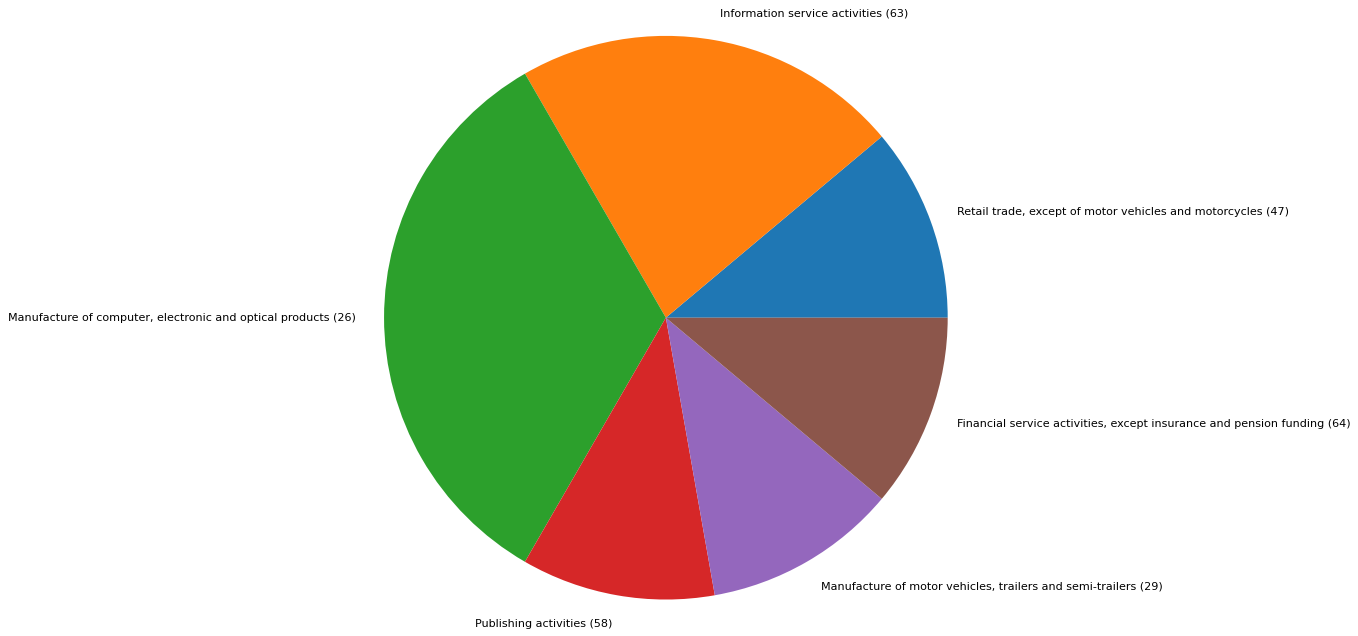

In [9]:
df_esg_constraint['weight'] = list(esg_ret_mvp['x'])

piesizes = calcWeightsForPieChart(df_esg_constraint)
plotPieChartWithNACELabels(nace_dict, piesizes)

## An approach to impact modeling
The idea behind impact investment is to invest specifically in companies that have a positive impact on social or environmental goals. Depending on the location or on the sector of economic activities, a high ESG Score can have a different impact -- for instance, a company that cares for clean drinking water has more impact in countries where clean water is actually an issue. Or using only renewable energies has much more impact in energy intense business sectors. We leave an evaluation of this kind of impact to experts in the field, and show here, how impact expertise can be included into our portfolio selection model.  
### Organization of impact information
We assume that wise people provide a score between 0 and 10 for each of the sectors covered by our universe. The score 0 means that an ESG-Rating exceeding the lower bound of 70 has no impact in this sector, whereas the score 10 implies a high impact of extra ESG points. To keep our example simple and illustrative, we just select one sector (construction of buildings, no. 41) which has the impact 10, and assume that all others have the impact 0 (for whatever reason). This impact information is assumed to be given by experts in a dictionary **nace_dict** with 2 digit NACE codes as keys and the respective impact score as values. 
You may use the commented line with random numbers for a more realistic setting of nace_dict. 
The impact scores are included into the instruments dataframe in the last line of the following code block. 

In [10]:
nace_impact_dict ={key: 0 for key in nace_dict.keys()}
nace_impact_dict['41']=10
#nace_impact_dict ={key: random.randint(0, 10) for key in nace_dict.keys()}
df_esg_constraint['nace_impact'] = df_esg_constraint['nace_code'].apply(lambda x: nace_impact_dict[x])

### Computation of the impact-ESG score of a portfolio
The **impact-ESG score** of a company now combines the ESG-Score with the sector impact score as follows: 

$$impactESG = impact \cdot (ESG - esgBound)$$

This formula is applied to each company in a dataframe of all companies in the optimization universe in the following line, 

In [11]:
impact_esg_score = lambda df: df['nace_impact']*(df['esg']-esg_bound)

and we compute some impact-ESG-scores of weighted portfolios in a scalar product as follows, 

In [12]:
mvp_impact_esg = numpy.dot(mvp['x'], impact_esg_score(df_esg_constraint))
mvp_ret_impact_esg = numpy.dot(esg_ret_mvp['x'], impact_esg_score(df_esg_constraint))
print('ESG of MVP: {mvpesg}\nImpact-ESG of MVP: {mvpiesg}\n'.format(mvpesg=numpy.dot(mvp['x'], df_esg_constraint['esg']), mvpiesg=mvp_impact_esg))
print('ESG of balanced: {balesg}\nImpact-ESG of balanced: {baliesg}'.format(balesg=numpy.dot(esg_ret_mvp['x'], df_esg_constraint['esg']), baliesg=mvp_ret_impact_esg))

ESG of MVP: 78.9849448645182
Impact-ESG of MVP: 0.0

ESG of balanced: 78.9849448645182
Impact-ESG of balanced: 0.0


Remember that the ESG-aware portfolio has a higher ESG-score than the basic MVP. 
But nevertheless, the impact-ESG score (which, in our example, sais that ESG-ratings higher than 70 make sense only for companies constructing buildings) is even decreased compared to the MVP. 
### Impact-ESG-aware portfolio selection
In order to build an impact-ESG-aware portfolio, we exchange the simple ESG-term with the impact-ESG term in the minimization problem. 

In [13]:
impact_esg_mvp = sco.minimize(lambda x: risk_measure(covMatrix, x) - 0.0002*numpy.dot(x, returns.sum()) - 0.000004*numpy.dot(x, impact_esg_score(df_esg_constraint)),  # function to be minimized
                   K * [1 / K],  # initial guess
                   bounds=bounds,  # boundary conditions
                   constraints =constraints,  # equality constraints
                   )


print('''Solution to weighted impact ESG problem in a universe with {K} instruments
Number of selected instruments: {n}
Minimum weight: {minw}
Maximum weight: {maxw}
Historical risk measure: {risk}
Historical return p.a.: {r}
ESG score: {esg}'''.format(K=K,
                           n=numpy.sum(impact_esg_mvp['x']>1e-4),
                           minw=numpy.min(impact_esg_mvp['x'][numpy.nonzero(impact_esg_mvp['x'])]),
                           maxw=numpy.max(impact_esg_mvp['x']),
                           risk=risk_measure(covMatrix, impact_esg_mvp['x']),
                           r=numpy.dot(impact_esg_mvp['x'],returns.sum()),
                           esg=numpy.dot(impact_esg_mvp['x'], df_esg_constraint['esg'])))

Solution to weighted impact ESG problem in a universe with 9 instruments
Number of selected instruments: 9
Minimum weight: 0.1111111111111111
Maximum weight: 0.1111111111111111
Historical risk measure: 0.0006730184693723141
Historical return p.a.: 0.7002503723783452
ESG score: 78.9849448645182


We compare the ESG- and impact-ESG-ratings of the three portfolios: 

In [14]:
mvp_impact_esg = numpy.dot(mvp['x'], impact_esg_score(df_esg_constraint))
mvp_ret_impact_esg = numpy.dot(esg_ret_mvp['x'], impact_esg_score(df_esg_constraint))

print('ESG of MVP: {esg}\nImpact-ESG of MVP: {iesg}\n'.format(
    esg=numpy.dot(mvp['x'], df_esg_constraint['esg']), 
    iesg=mvp_impact_esg))

print('ESG of return and ESG balanced: {esg}\nImpact-ESG of return and ESG balanced: {iesg}\n'.format(
    esg=numpy.dot(esg_ret_mvp['x'], df_esg_constraint['esg']),
    iesg=mvp_ret_impact_esg))
print('ESG of return and impact-ESG balanced: {esg}\nImpact-ESG of return and impact-ESG balanced: {iesg}\n'.format(
    esg=numpy.dot(impact_esg_mvp['x'], df_esg_constraint['esg']), 
    iesg=numpy.dot(impact_esg_mvp['x'], impact_esg_score(df_esg_constraint))))

ESG of MVP: 78.9849448645182
Impact-ESG of MVP: 0.0

ESG of return and ESG balanced: 78.9849448645182
Impact-ESG of return and ESG balanced: 0.0

ESG of return and impact-ESG balanced: 78.9849448645182
Impact-ESG of return and impact-ESG balanced: 0.0



In fact, the impact-ESG optimization was successful: The respective portfolio achieves a much higher impact-ESG-score than the competing portfolios. 

We also plot the business sectors pie chart and of course, the impact-ESG-aware portfolio has a special focus on the construction of buildings: 

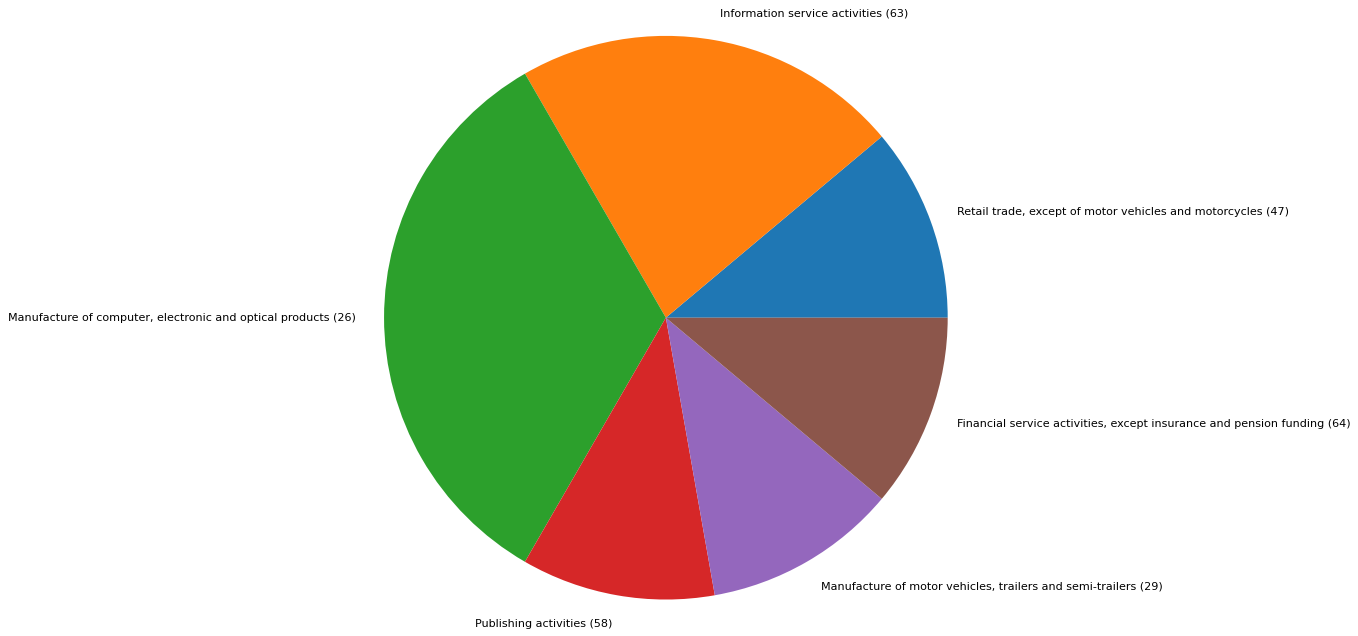

In [15]:
df_esg_constraint['weight'] = impact_esg_mvp['x']

piesizes = calcWeightsForPieChart(df_esg_constraint)
plotPieChartWithNACELabels(nace_dict, piesizes)

## Resume and outlook
We hope that we could show, how different aspects and criteria can be considered in a portfolio selection strategy. We have constructed 3 portfolios: All of them satisfy a lower bound on the ESG-score in every constituent. By using specific objective functions in the minimization problem, we could steer the distribution of the investment to have low volatility in the first one, and a trade-of between low volatility but also high returns and high ESG-scores in the second one. For the third portfolio, we showed a model for impact-ESG scores and included it into the optimization goal. 

This tutorial aims to show some key techniques and thus scratches only the surface of ESG- and risk-aware portfolio selection. One can refine the models in many aspects, and one could go for more details in the analysis of the results. We refer to the literature and to the large pool of Refinitiv tutorials in the developers' community. 